Importación de las bibliotecas

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Sistema de recomendación usando una proyección de red bipartita

**Integrantes:** Isaac Cerda, David Guamán, Christian Jácome, Mateo Jaramillo, David Navarrete

## Preparación de Datos

### **Paso 1:** Descargar el Dataset
Ejecutar **SOLO** si **NO** se tiene la carpeta `data` en el directorio `src/app` con el archivo `ratings_electronics.csv`

In [1]:
from utils.download_dataset import download_ratings_electronics

dataset_path = download_ratings_electronics()

El archivo ya está disponible en: data\amazon-products-reviews\ratings_electronics.csv


### **Paso 2:** Cargar el Dataset

In [2]:
import pandas as pd

## Carga del dataset generado en la ruta del api
electronics_data = pd.read_csv(
    dataset_path, names=['userId', 'productId', 'Rating', 'timestamp']
)

## Impresión de las primeras 5 filas para validar la carga correcta del dataset
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


#### **Paso 2.1:** Revisar cantidad de datos del Dataset

In [3]:
electronics_data.info()
electronics_data.describe()
print(f"Total registros: {len(electronics_data):,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB
Total registros: 7,824,482


### **Paso 3:** Filtrar reseñas de 5 estrellas

In [4]:
electronics_data = electronics_data[electronics_data['Rating'] == 5]
print(f"Registros luego de filtrar 5 estrellas: {len(electronics_data):,}")

Registros luego de filtrar 5 estrellas: 4,347,541


### **Paso 4:** Eliminar usuarios y productos con pocas conexiones

In [5]:
# Contar cuántos ratings tiene cada usuario y producto
user_counts = electronics_data['userId'].value_counts()
product_counts = electronics_data['productId'].value_counts()

# Mantener usuarios y productos con al menos 4 interacciones
min_user_reviews = 4
min_product_reviews = 4

filtered_users = user_counts[user_counts >= min_user_reviews].index
filtered_products = product_counts[product_counts >= min_product_reviews].index

electronics_data = electronics_data[
    electronics_data['userId'].isin(filtered_users) &
    electronics_data['productId'].isin(filtered_products)
]

print(f"Registros tras filtrado de conexiones mínimas: {len(electronics_data):,}")


Registros tras filtrado de conexiones mínimas: 1,147,489


#### **Paso 4.1:** Validar campos nulos tras el filtrado

In [6]:
electronics_data.isnull().sum()

userId       0
productId    0
Rating       0
timestamp    0
dtype: int64

## Construcción de la Red Bipartita

Una red bipartita es una forma de organizar relaciones entre dos grupos distintos. En este caso se tiene dos filas: una con usuarios y otra con productos. Las conexiones, también llamadas aristas, solo pueden ir de un grupo al otro, nunca dentro del mismo grupo. Por ejemplo, un usuario puede dar 5 estrellas a un producto, pero un usuario no se conecta con otro usuario, ni un producto con otro producto.

### Artefactos:

- **Matriz de biadyacencia**: Una tabla que muestra las conexiones. Las filas son usuarios, las columnas son productos, un "1" indica que el usuario dio 5 estrellas al producto y un "0" si no.

- **Grado de un nodo:** Cuántas conexiones tiene un nodo (por ejemplo, cuántos productos calificó un usuario, o cuántas reseñas de 5 estrellas recibió un producto).

### **Paso 1:** Reducir cantidad de Nodos

Debido a que el dataset es muy grande, se toma una muestra

In [7]:
import random

users = electronics_data['userId'].unique()
products = electronics_data['productId'].unique()

print("Antes de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

users = list(users)
products = list(products)

sample_ratio = 0.1

num_users = int(len(users) * sample_ratio)
num_products = int(len(products) * sample_ratio)

random.seed(42)
users = random.sample(users, num_users)
products = random.sample(products, num_products)

print("Después de la muestra:")
print(f"Número de usuarios únicos: {len(users)}")
print(f"Número de productos únicos: {len(products)}")

Antes de la muestra:
Número de usuarios únicos: 184707
Número de productos únicos: 107686
Después de la muestra:
Número de usuarios únicos: 18470
Número de productos únicos: 10768


### **Paso 2:** Crear red bipartita

In [8]:
import networkx as nx

B = nx.Graph()

# Agregar nodos al grafo
B.add_nodes_from(users, bipartite=0)
B.add_nodes_from(products, bipartite=1)

# Agregar aristas
edges = electronics_data[['userId', 'productId']].values
B.add_edges_from(edges)

is_bipartite = nx.is_bipartite(B)
print(f"¿Es el grafo bipartito? {"Sí" if is_bipartite else "No"}")
num_edges = B.number_of_edges()
print("Número de aristas:", num_edges)

¿Es el grafo bipartito? Sí
Número de aristas: 1147489


### **Paso 3:** Generar matriz de biadyacencia

Se utiliza la matriz de biadyacencia dispersa, que es una forma eficiente de representar grandes grafos bipartitos en memoria.
Cada fila representa un usuario y cada columna un producto; los valores distintos de cero indican una conexión (por ejemplo, que el usuario interactuó con o compró ese producto).

La razón principal para trabajar con una matriz dispersa (sparse) en lugar de una matriz completa (toarray()) es que la mayoría de las celdas son ceros — es decir, la mayoría de los usuarios no se conectan con todos los productos.
Usar una matriz dispersa permite ahorrar memoria y procesar grafos grandes de forma mucho más eficiente.

In [10]:
from networkx.algorithms import bipartite
import pandas as pd

# Obtener matriz de biadyacencia en formato disperso (sparse)
matrix_sparse = bipartite.biadjacency_matrix(B, row_order=users, column_order=products)

# Mostrar información general de la matriz
print("Matriz de biadyacencia (formato disperso):")
print(matrix_sparse)
print(f"Tamaño: {matrix_sparse.shape}")
print(f"Número de conexiones (valores distintos de 0): {matrix_sparse.nnz}")

# Extraer los índices (posiciones) de los valores distintos de cero
row_idx, col_idx = matrix_sparse.nonzero()

# Crear un DataFrame con los enlaces reales (usuario - producto)
edges_nonzero = pd.DataFrame({
    'userId': [users[i] for i in row_idx],
    'productId': [products[j] for j in col_idx]
})

print("\nConexiones reales (valores distintos de 0):")
print(edges_nonzero.head(10))  # Muestra solo los primeros 10 para no saturar la salida

Matriz de biadyacencia (formato disperso):
<Compressed Sparse Row sparse array of dtype 'int64'
	with 11532 stored elements and shape (18470, 10768)>
  Coords	Values
  (2, 5156)	1
  (5, 5693)	1
  (5, 10206)	1
  (7, 11)	1
  (9, 1123)	1
  (10, 575)	1
  (10, 1837)	1
  (10, 3982)	1
  (10, 6990)	1
  (12, 7294)	1
  (14, 6874)	1
  (15, 9333)	1
  (16, 8018)	1
  (17, 1170)	1
  (20, 510)	1
  (20, 2456)	1
  (25, 9357)	1
  (28, 969)	1
  (32, 5573)	1
  (33, 1508)	1
  (34, 1949)	1
  (34, 2074)	1
  (41, 3838)	1
  (42, 1328)	1
  (44, 3414)	1
  :	:
  (18443, 7159)	1
  (18445, 9996)	1
  (18448, 3799)	1
  (18448, 10741)	1
  (18450, 276)	1
  (18450, 1543)	1
  (18450, 1802)	1
  (18450, 2037)	1
  (18450, 4422)	1
  (18450, 6596)	1
  (18450, 8436)	1
  (18450, 9591)	1
  (18450, 10404)	1
  (18452, 9644)	1
  (18457, 5665)	1
  (18459, 1543)	1
  (18459, 3397)	1
  (18459, 5650)	1
  (18459, 7432)	1
  (18459, 10737)	1
  (18460, 9124)	1
  (18461, 9643)	1
  (18466, 6169)	1
  (18467, 10730)	1
  (18469, 2694)	1
Tamaño: (

### **Paso 4:** Graficar nodos con mayores conexiones

Se calculan los grados de los nodos (número de conexiones):

- `num_products_rated`: cuántos productos calificó cada usuario.
- `num_ratings_received`: cuántos usuarios calificaron cada producto.

Luego se seleccionan los Top N nodos más conectados en cada grupo `nlargest`.


Grados de los primeros usuarios:
           userId  num_products_rated
0  A3RNVG2VPZGC6Z                   4
1  A2MLPFHL4YOZX0                   7
2  A22M9RH5461NC9                   9
3  A2B09MGT1H44LY                   5
4  A24L9693W832UC                   4

Grados de los primeros productos:
    productId  num_ratings_received
0  B0041NO0EY                     1
1  B000VOUSPC                     1
2  B0054OWTCO                     2
3  B0052UQXFY                     8
4  B000J4WPW8                    56


C:\Users\chris\AppData\Local\Temp\ipykernel_39176\2185075639.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
C:\Users\chris\AppData\Local\Temp\ipykernel_39176\2185075639.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")


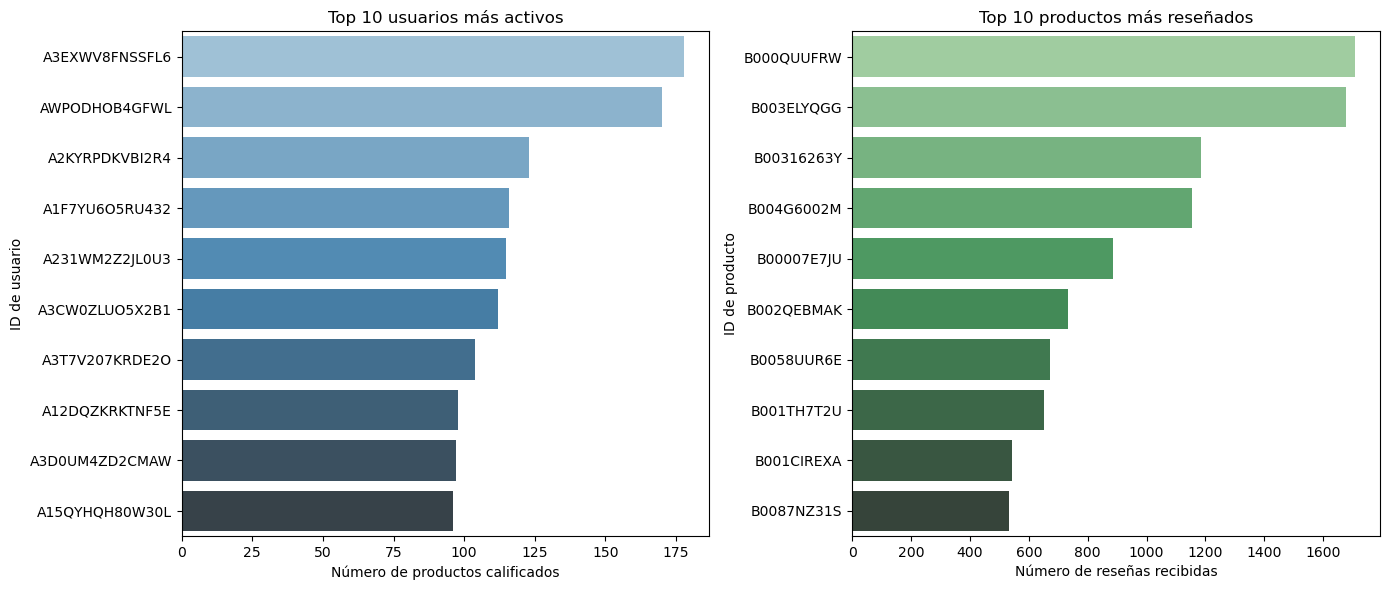

In [15]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import seaborn as sns

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

user_deg_df = pd.DataFrame(user_degrees.items(), columns=["userId", "num_products_rated"])
product_deg_df = pd.DataFrame(product_degrees.items(), columns=["productId", "num_ratings_received"])

print("\nGrados de los primeros usuarios:")
print(user_deg_df.head())

print("\nGrados de los primeros productos:")
print(product_deg_df.head())

# --- Top N nodos ---
N = 10
top_users = user_deg_df.nlargest(N, "num_products_rated")
top_products = product_deg_df.nlargest(N, "num_ratings_received")

plt.figure(figsize=(14, 6))

# Top N usuarios más activos
plt.subplot(1, 2, 1)
sns.barplot(data=top_users, x="num_products_rated", y="userId", palette="Blues_d")
plt.title(f"Top {N} usuarios más activos")
plt.xlabel("Número de productos calificados")
plt.ylabel("ID de usuario")

# Top N productos más reseñados
plt.subplot(1, 2, 2)
sns.barplot(data=top_products, x="num_ratings_received", y="productId", palette="Greens_d")
plt.title(f"Top {N} productos más reseñados")
plt.xlabel("Número de reseñas recibidas")
plt.ylabel("ID de producto")

plt.tight_layout()
plt.show()


#### **Paso 4.1:** Mostrar resultado final

In [19]:
import numpy as np

# Calcular grados de los usuarios y productos
user_degrees = dict(B.degree(users))
product_degrees = dict(B.degree(products))

print(f"Número de usuarios: {len(users)}")
print(f"Número de productos: {len(products)}")
print(f"Número de aristas (reseñas de 5 estrellas): {B.number_of_edges()}")
print(f"Grado promedio de usuarios: {np.mean(list(user_degrees.values())):.2f}")
print(f"Grado promedio de productos: {np.mean(list(product_degrees.values())):.2f}")

Número de usuarios: 18470
Número de productos: 10768
Número de aristas (reseñas de 5 estrellas): 1147489
Grado promedio de usuarios: 6.19
Grado promedio de productos: 10.82


## Proyección Bipartita y Red de Productos

## Desarrollo del Sistema de Recomendación

## Visualización, Análisis e Interactividad